In [84]:
import nfl_data_py as nfl
import pandas as pd
import os
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.image as mpimg
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim

In [12]:
pip install nfl_data_py==0.3.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 60.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pandas: filename=pandas-1.5.3-cp312-cp312-macosx_11_0_arm64.whl size=10140864 sha256=5d0a742cd175df437a7749c160de702ce07263321b3620dd268f613bd3d5fcb8
  Stored in directory: /Users/kevinstrouse/Library/Caches/pip/wheels/fb/83/18/8e7307aa1185c5498c5490e4d9c8a1732d9f1056e86c3491c6
Successfully built pandas
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: nfl_data_py
    Found existing installation: nfl_data_py 0.3.1
    Uninstalling nfl_data_py-0.3.1:
      Successfully uninstalled nfl_data_py-0.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is th

In [17]:
pip show nfl_data_py

Name: nfl_data_py
Version: 0.3.3
Summary: python library for interacting with NFL data sourced from nflfastR
Home-page: https://github.com/nflverse/nfl_data_py
Author: Alec Ostrander
Author-email: alec.ostrander@gmail.com
License: MIT
Location: /opt/anaconda3/lib/python3.12/site-packages
Requires: appdirs, fastparquet, numpy, pandas
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [68]:
#data cleaning; remove entries that don't have pass or run

pbp_df_current = nfl.import_pbp_data([2024], downcast=True, cache=False, alt_path=None, include_participation=False)
pbp_df_current = pbp_df_current.loc[(pbp_df_current.play_type.isin(['no_play','pass','run'])) & (pbp_df_current.epa.isna()==False)]
df_twofour = pbp_df_current[(pbp_df_current["season_type"] == "REG") & (pbp_df_current['pass'] == 1) | (pbp_df_current['rush'] == 1)]

df_twofour.head()
df_twofour = pbp_df_current[(pbp_df_current["season_type"] == "REG") & (pbp_df_current['pass'] == 1) | (pbp_df_current['rush'] == 1)]
df_twofour.head()

2024 done.
Downcasting floats.


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
2,61.0,2024_01_ARI_BUF,2024090801,BUF,ARI,REG,1,ARI,away,BUF,...,0.0,0.0,-0.200602,NaN,NaN,NaN,NaN,NaN,0.456761,-45.676102
3,83.0,2024_01_ARI_BUF,2024090801,BUF,ARI,REG,1,ARI,away,BUF,...,0.0,0.0,2.028874,1.345418,9.321221,8.0,0.509778,0.363807,0.576656,42.334431
4,108.0,2024_01_ARI_BUF,2024090801,BUF,ARI,REG,1,ARI,away,BUF,...,0.0,0.0,0.754242,0.882798,5.783560,4.0,0.668478,0.255140,0.426443,57.355690
5,133.0,2024_01_ARI_BUF,2024090801,BUF,ARI,REG,1,ARI,away,BUF,...,0.0,0.0,-0.029602,NaN,NaN,NaN,NaN,NaN,0.225364,-22.536427
6,155.0,2024_01_ARI_BUF,2024090801,BUF,ARI,REG,1,ARI,away,BUF,...,0.0,0.0,-0.247749,NaN,NaN,NaN,NaN,NaN,0.424099,-42.409935


In [69]:
df_twofour.columns.values

array(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       'side_of_field', 'yardline_100', 'game_date',
       'quarter_seconds_remaining', 'half_seconds_remaining',
       'game_seconds_remaining', 'game_half', 'quarter_end', 'drive',
       'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo',
       'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun',
       'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble',
       'pass_length', 'pass_location', 'air_yards', 'yards_after_catch',
       'run_location', 'run_gap', 'field_goal_result', 'kick_distance',
       'extra_point_result', 'two_point_conv_result',
       'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout',
       'timeout_team', 'td_team', 'td_player_name', 'td_player_id',
       'posteam_timeouts_remaining', 'defteam_timeouts_remaining',
       'total_home_score', 'total_away_score', 'posteam_score'

In [72]:
# Create DataFrame with columns for home and away teams, yards gained, and points scored for home and away

df_simple = df_twofour[['game_id', 'home_team', 'away_team', 'posteam', 'yards_gained', 'total_home_score', 'total_away_score']].copy().reset_index()
df_simple.head()

,index,game_id,home_team,away_team,posteam,yards_gained,total_home_score,total_away_score
0,2,2024_01_ARI_BUF,BUF,ARI,ARI,3.0,0.0,0.0
1,3,2024_01_ARI_BUF,BUF,ARI,ARI,22.0,0.0,0.0
2,4,2024_01_ARI_BUF,BUF,ARI,ARI,9.0,0.0,0.0
3,5,2024_01_ARI_BUF,BUF,ARI,ARI,2.0,0.0,0.0
4,6,2024_01_ARI_BUF,BUF,ARI,ARI,2.0,0.0,0.0


In [73]:
#aggregate total yards per game and max points per game for home team

df_home = df_simple[df_simple['posteam'] == df_simple['home_team']]

df_home = (
    df_home.groupby(['game_id', 'home_team'], as_index=False)
    .agg({
        'yards_gained': 'sum',
        'total_home_score': 'max'
    })
    .rename(columns={
        'game_id': 'Game ID', 
        'home_team': 'Home Team', 
        'yards_gained': 'Total Yards', 
        'total_home_score': 'Home Team Score'
    })
)
df_home

,Game ID,Home Team,Total Yards,Home Team Score
0,2024_01_ARI_BUF,BUF,353.0,31.0
1,2024_01_BAL_KC,KC,354.0,27.0
2,2024_01_CAR_NO,NO,379.0,47.0
3,2024_01_DAL_CLE,CLE,230.0,16.0
4,2024_01_DEN_SEA,SEA,308.0,26.0
...,...,...,...,...
146,2024_10_NYJ_ARI,ARI,407.0,31.0
147,2024_10_PHI_DAL,DAL,146.0,6.0
148,2024_10_PIT_WAS,WAS,242.0,27.0
149,2024_10_SF_TB,TB,215.0,17.0


In [74]:
#do the same for away teams

df_away = df_simple[df_simple['posteam'] == df_simple['away_team']]

df_away = (
    df_away.groupby(['game_id', 'away_team'], as_index=False)
    .agg({
        'yards_gained': 'sum',
        'total_away_score': 'max'
    })
    .rename(columns={
        'game_id': 'Game ID', 
        'away_team': 'Away Team', 
        'yards_gained': 'Total Yards', 
        'total_away_score': 'Away Team Score'
    })
)
df_away


,Game ID,Away Team,Total Yards,Away Team Score
0,2024_01_ARI_BUF,ARI,273.0,28.0
1,2024_01_BAL_KC,BAL,452.0,20.0
2,2024_01_CAR_NO,CAR,193.0,10.0
3,2024_01_DAL_CLE,DAL,266.0,33.0
4,2024_01_DEN_SEA,DEN,231.0,19.0
...,...,...,...,...
146,2024_10_NYJ_ARI,NYJ,207.0,6.0
147,2024_10_PHI_DAL,PHI,349.0,34.0
148,2024_10_PIT_WAS,PIT,315.0,28.0
149,2024_10_SF_TB,SF,414.0,20.0


In [76]:
#rename columns for consistency to prepare for data merge
df_home_rename = (
        df_home.rename(columns={'game_id': 'Game ID', 'Home Team': 'Team', 'Total Yards' : 'Yards', 'Home Team Score': 'Score'})
        .reset_index(drop=True)
    )

df_away_rename = df_away_rename = (
        df_away.rename(columns={'game_id': 'Game ID', 'Away Team': 'Team', 'Total Yards' : 'Yards', 'Away Team Score': 'Score'})
        .reset_index(drop=True)
    )

#Merge home and away stats

df_merged = (
    
        pd.concat([df_home_rename, df_away_rename], axis=0)
        .reset_index(drop=True)
    )

df_merged

,Game ID,Team,Yards,Score
0,2024_01_ARI_BUF,BUF,353.0,31.0
1,2024_01_BAL_KC,KC,354.0,27.0
2,2024_01_CAR_NO,NO,379.0,47.0
3,2024_01_DAL_CLE,CLE,230.0,16.0
4,2024_01_DEN_SEA,SEA,308.0,26.0
...,...,...,...,...
297,2024_10_NYJ_ARI,NYJ,207.0,6.0
298,2024_10_PHI_DAL,PHI,349.0,34.0
299,2024_10_PIT_WAS,PIT,315.0,28.0
300,2024_10_SF_TB,SF,414.0,20.0


In [82]:
#get mean numbers per team
team_stats = (
    df_merged.groupby('Team')
    .agg({
        'Yards': 'mean',  # Average yards per game
        'Score': 'mean'   # Average score per game
    })
    .reset_index()
    .rename(columns={'Yards': 'Avg Yards', 'Score': 'Avg Score'})
)

# Display team_stats to verify
print(team_stats.head())




  Team   Avg Yards  Avg Score
0  ARI  347.700012       22.6
1  ATL  377.299988       23.1
2  BAL  438.600006       31.4
3  BUF  344.600006       28.1
4  CAR  281.399994       16.0


In [107]:
logos = nfl.import_team_desc()[['team_abbr', 'team_logo_espn']]
logos.head()

,team_abbr,team_logo_espn
0,ARI,https://a.espncdn.com/i/teamlogos/nfl/500/ari.png
1,ATL,https://a.espncdn.com/i/teamlogos/nfl/500/atl.png
2,BAL,https://a.espncdn.com/i/teamlogos/nfl/500/bal.png
3,BUF,https://a.espncdn.com/i/teamlogos/nfl/500/buf.png
4,CAR,https://a.espncdn.com/i/teamlogos/nfl/500-dark...


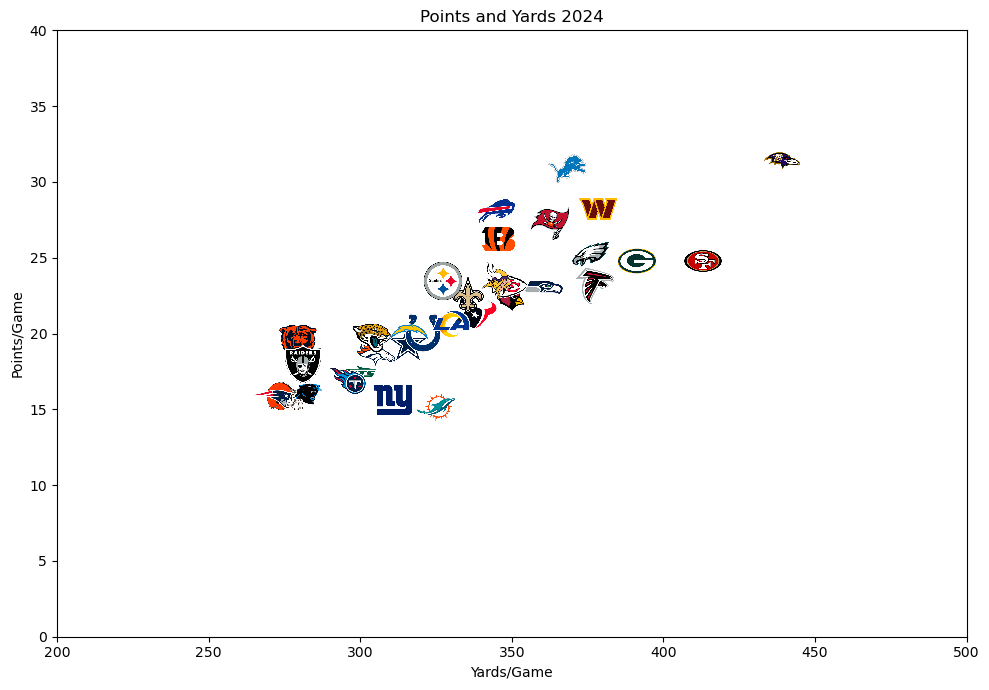

In [109]:
# Ensure 'logos' directory exists and download logos
logo_paths = []
team_abbr = []

if not os.path.exists("logos"):
    os.makedirs("logos")

# Download team logos
for team in range(len(logos)):
    logo_url = logos['team_logo_espn'][team]
    team_code = logos['team_abbr'][team]
    logo_path = f"logos/{team_code}.tif"
    urllib.request.urlretrieve(logo_url, logo_path)
    
    # Images vary in size, so use PIL to make sure all logos have the same size
    img = Image.open(logo_path)
    img = img.resize((300, 300))  
    img.save(logo_path)
    
    logo_paths.append(logo_path)
    team_abbr.append(team_code)

# Create DataFrame for logos
logo_data = pd.DataFrame({'team_abbr': team_abbr, 'logo_path': logo_paths})

# Merge logos with team statistics data
team_stats_with_logos = pd.merge(team_stats, logo_data, left_on='Team', right_on='team_abbr')

# Plot settings
plt.rcParams["figure.figsize"] = [10, 7]
plt.rcParams["figure.autolayout"] = True

# Function to get a resized image
def getImage(path, zoom=0.20):
    img = plt.imread(path, format="tif")
    return OffsetImage(img, zoom=zoom)

# Define x, y, and paths for plotting
x = team_stats_with_logos['Avg Yards']
y = team_stats_with_logos['Avg Score']
paths = team_stats_with_logos['logo_path']

# Create figure and axis
fig, ax = plt.subplots()

# Plot each logo at the corresponding x, y coordinates
for x0, y0, path in zip(x, y, paths):
    ab = AnnotationBbox(getImage(path, zoom=0.1), (x0, y0), frameon=False)
    ax.add_artist(ab)

# Set axis limits and labels
plt.xlim(200, 500)
plt.ylim(0, 40)
plt.title("Points and Yards 2024")
plt.xlabel("Yards/Game")
plt.ylabel("Points/Game")

# Save the figure as a PNG file
plt.savefig("rush_pass_epa_plot.png", format="png", dpi=300, bbox_inches="tight")


# Show plot
plt.show()